# Logistic Regression
Compare sklearn, spark ML, and homegrown GD

### Notebook setup

In [620]:
# general imports
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### sklearn

In [854]:
# ML modules
#importing all the required ML packages
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as LogisticRegression_skl
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix


### Spark

In [66]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "LR"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [66]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [870]:
from pyspark.mllib.classification import LogisticRegressionWithSGD, LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics

## Dataset:
### Titanic - just going to clean it up for training. Not doing anything special.
https://www.kaggle.com/c/titanic/data

In [41]:
data=pd.read_csv('titanic_data/train.csv')

In [42]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2


In [44]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_band,Fare_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,3


In [45]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_band,Fare_cat
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0.0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1.0,2,3


In [46]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_band', 'Fare_cat'],
      dtype='object')

In [47]:
data.drop(['Name','Age','Ticket','Fare','Cabin','PassengerId'],axis=1,inplace=True)

In [54]:
data['Embarked'].fillna(0,inplace=True)

In [55]:
data.head(2)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_band,Fare_cat
0,0,3,0,1,0,0.0,1,0
1,1,1,1,1,0,1.0,2,3


In [471]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

## Normalize


In [569]:
cols = train_X.columns
# "Pclass", "Sex", "SibSp","Parch","Embarked","Age_band","Fare_cat"
len(train_X)

623

In [477]:
scaler = preprocessing.StandardScaler().fit(train[cols])
train[cols] = scaler.transform(train[cols]) 
test[cols] = scaler.transform(test[cols]) 

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [478]:
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]

In [510]:
train_X.head(3)

,Pclass,Sex,SibSp,Parch,Embarked,Age_band,Fare_cat
231,0.843816,-0.73626,-0.480922,-0.479735,-0.557316,-0.078633,-1.361838
836,0.843816,-0.73626,-0.480922,-0.479735,-0.557316,-0.078633,-0.462130
639,0.843816,-0.73626,0.449557,-0.479735,-0.557316,-1.120937,0.437579


# TRAIN MODELS

## SKLearn l-BFGS

In [871]:
# PARAMS:
# penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None

model = LogisticRegression_skl(max_iter=100, C=10.0, penalty='l2', solver="lbfgs")
model.fit(train_X,train_Y)
sk_pred = model.predict(test_X)


/opt/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [872]:
# testing accuracy
metrics.accuracy_score(sk_pred,test_Y)

0.7835820895522388

In [874]:
# Print the coefficients and intercept for logistic regression, and save for later
SKL_lBFGS_Coefficients = model.coef_[0]
SKL_lBFGS_Intercept = model.intercept_[0]
print("Coefficients: " + str(SKL_lBFGS_Coefficients))
print("Intercept: " + str(SKL_lBFGS_Intercept))

Coefficients: [-0.66990893  1.26828286 -0.50326023  0.0039009   0.04510169 -0.34592398
  0.43795409]
Intercept: -0.6697116236419611


## SKLearn SGD

In [865]:
clf = SGDClassifier(max_iter=100, loss='log', penalty='l2', alpha=0.1)
clf.fit(train_X,train_Y)

/opt/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [866]:
SGD_Coefficients = clf.coef_[0]
SGD_Intercept = clf.intercept_[0]
print("Coefficients: " + str(SGD_Coefficients))
print("Intercept: " + str(SGD_Intercept))

Coefficients: [-0.38286659  0.75166054 -0.18526143  0.03908747  0.07512945 -0.10103944
  0.27221746]
Intercept: -0.5606732762947044


## Spark ML

In [483]:
# Load training data
training = spark.createDataFrame(train)
testing = spark.createDataFrame(test)

In [484]:
# vectorize features
training = VectorAssembler(inputCols=["Pclass", "Sex", "SibSp","Parch","Embarked","Age_band","Fare_cat"], outputCol="features").transform(training)
testing = VectorAssembler(inputCols=["Pclass", "Sex", "SibSp","Parch","Embarked","Age_band","Fare_cat"], outputCol="features").transform(testing)

In [512]:
lr = LogisticRegression(featuresCol="features", labelCol="Survived", maxIter=100, regParam=0.1, elasticNetParam=0)
# elasticNetParam: For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.

# Fit the model
lrModel = lr.fit(training)

In [630]:
# Print the coefficients and intercept for logistic regression, and save for later
SML_Coefficients = ast.literal_eval(str(lrModel.coefficients))
SML_Intercept = lrModel.intercept
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-0.38276327726064785,0.7511534778999847,-0.18501210699224013,0.039150594029284135,0.07504441253288861,-0.10084820705987879,0.2721938767792715]
Intercept: -0.5605990457370776


In [514]:
# traing accuracy
lrModel.summary.accuracy

0.8009630818619583

In [513]:
result = lrModel.transform(testing)

In [632]:
# testing accuracy
lrModel.evaluate(testing).accuracy

0.8059701492537313

## Spark MLLib

In [771]:
# lr_sgd = LogisticRegressionWithSGD(featuresCol="features", labelCol="Survived", maxIter=100, regParam=0.1, elasticNetParam=0)
# elasticNetParam: For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.
trainingRDD = spark.createDataFrame(train).rdd.map(lambda row: LabeledPoint(row[0], row[1:])).cache()
testingRDD = spark.createDataFrame(test).rdd.map(lambda row: LabeledPoint(row[0], row[1:])).cache()

### LogisticRegressionWithLBFGS

In [805]:
SMLLib_LBFGS = LogisticRegressionWithLBFGS.train(trainingRDD, regType='l2', regParam=0.1, iterations=100, intercept=True)

In [811]:
SMLLib_LBFGS_Coefficients = SMLLib_LBFGS.weights
SMLLib_LBFGS_Intercept = SMLLib_LBFGS.intercept
print("Coefficients: " + str(SMLLib_LBFGS.weights))
print("Intercept: " + str(SMLLib_LBFGS.intercept))

Coefficients: [-0.38276312308288346,0.7511534609531584,-0.18501261374642466,0.03914924986616064,0.07504488801463349,-0.10084866999250106,0.2721944710930208]
Intercept: -0.5605997085040088


### LogisticRegressionWithSGD

In [861]:
SMLLib_SGD = LogisticRegressionWithSGD.train(trainingRDD, regType='l2', regParam=0.1, iterations=100, intercept=True)

In [862]:
SMLLib_SGD_Coefficients = SMLLib_SGD.weights
SMLLib_SGD_Intercept = SMLLib_SGD.intercept
print("Coefficients: " + str(SMLLib_SGD.weights))
print("Intercept: " + str(SMLLib_SGD.intercept))

Coefficients: [-0.36906189210358004,0.7314138634052907,-0.17293552613634094,0.03997256718961476,0.07588008718680454,-0.08834162935347484,0.2627801292300035]
Intercept: -0.3495550061240263


__Evaluation (AOC):__
https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#module-pyspark.mllib.evaluation

## Spark RDD - homegrown

In [489]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [669]:
def LogLoss(dataRDD, W): 
    """
    Compute logistic loss error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    loss = augmentedData.map(lambda x: x[1]*np.log(sigmoid(W.dot(x[0]))) + (1-x[1])*np.log(1 - sigmoid(W.dot(x[0])))).mean()*-1
   
    ################## (END) YOUR CODE ##################
    return loss

In [694]:

def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType='ridge', regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    N=dataRDD.count()
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    new_model = None
    #################### YOUR CODE HERE ###################
    # Use the same way as before to find the first component of the gradient function
    # Note: the official equation should be a sum() which provides a lower log loss and a more accurate prediction.
    # However, Spark ML uses mean() for their calculation, possibly to avoid overflow issues.
    
    grad = augmentedData.map(lambda x: ((sigmoid(W.dot(x[0])) - x[1])*x[0])).sum()
    if regType == 'ridge':
        grad += regParam * np.append([0.0], W[1:])
    elif regType == 'lasso':
        grad += regParam * np.append([0.0], np.sign(W)[1:])
    new_model = W - learningRate * grad/N
    ################## (END) YOUR CODE ####################
    return new_model

In [695]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 100, learningRate = 0.1,
                         regType='ridge', regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(LogLoss(trainRDD, model))
        test_history.append(LogLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [696]:
trainRDD = spark.createDataFrame(train).rdd.map(lambda x: (x[1:],x[0]))
testRDD = spark.createDataFrame(test).rdd.map(lambda x: (x[1:],x[0]))

In [697]:
wInit = np.random.uniform(0,1,8)
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 500, regType='ridge', regParam = 0.1 )

In [698]:
# intercept and coefficients
HG_Coefficients = ridge_results[2][-1][1:]
HG_Intercept = ridge_results[2][-1][:1][0]
print("Intercept: " + str(HG_Intercept))
print("Coefficients: " + str(HG_Coefficients))

Intercept: -0.6610785171605804
Coefficients: [-0.64503088  1.25475282 -0.48088803 -0.00443412  0.05368445 -0.32260184
  0.44338123]


In [699]:
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    if title:
        plt.title(title)
    plt.show()

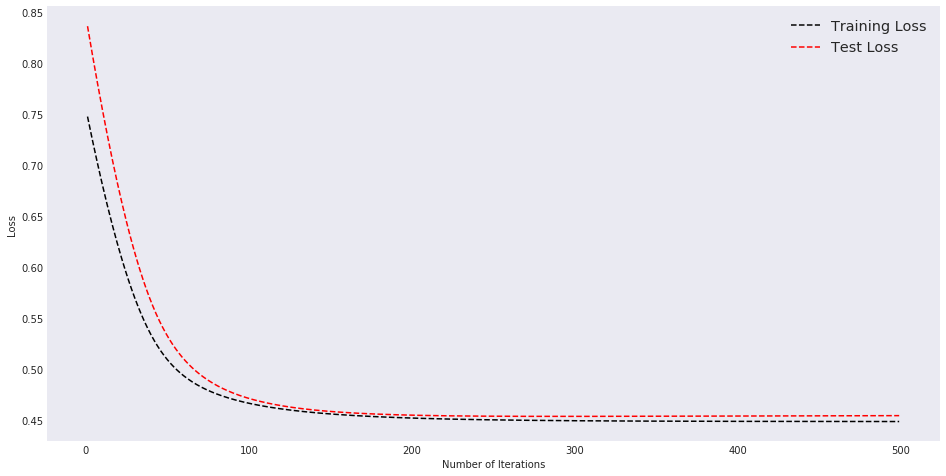

In [700]:
plotErrorCurves(ridge_results[0],ridge_results[1])

In [701]:
# predict probabilities for homegrown
w = ridge_results[2][-1] # final model
augmentedTestData = testRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
results = augmentedTestData.map(lambda x: (sigmoid(w.dot(x[0])),x[1])).collect()

In [702]:
# set prediction to 1 if probability is greater than or equal to 0.5, and 0 otherwise.
df = pd.DataFrame(results)
df['pred'] = df[0] >= .5

In [703]:
# testing accuracy
sum(df['pred']==df[1])/len(df)

0.7835820895522388

In [679]:
# testing accuracy
sum(df['pred']==df[1])/len(df)

0.8059701492537313

## MODELS

In [877]:
# Pretty Print
print("{:15s}\t| {:15s}\t| {:15s}\t| {:15s}\t| {:15s}\t| {}" \
      .format("Homegrown",
              "Spark ML (l-BFGS)",
              "MLLib l-BFGS",
              "MLLib SGD",
              "SKLearn SGD",
              "SKLearn l-BFGS"
             ))
print("="*130)
print("Coefficients")   
print("-"*130)  
for r in range(7):
    print ("{:15.8f}\t| {:15.8f}\t| {:15.8f}\t| {:15.8f}\t| {:15.8f}\t| {:15.8f}" \
           .format(HG_Coefficients[r],
                   SML_Coefficients[r],
                   SMLLib_LBFGS_Coefficients[r],
                   SMLLib_SGD_Coefficients[r],
                   SGD_Coefficients[r],
                   SKL_lBFGS_Coefficients[r]
                  ))
print("-"*130)    
print("Intercept")   
print("-"*130)   
print ("{:15.8f}\t| {:15.8f}\t| {:15.8f}\t| {:15.8f}\t| {:15.8f}\t| {:15.8f}" \
       .format(HG_Intercept,
               SML_Intercept,
               SMLLib_LBFGS_Intercept,
               SMLLib_SGD_Intercept,
               SGD_Intercept,
               SKL_lBFGS_Intercept
              ))    


Homegrown      	| Spark ML (l-BFGS)	| MLLib l-BFGS   	| MLLib SGD      	| SKLearn SGD    	| SKLearn l-BFGS
Coefficients
----------------------------------------------------------------------------------------------------------------------------------
    -0.64503088	|     -0.38276328	|     -0.38276312	|     -0.36906189	|     -0.38286659	|     -0.66990893
     1.25475282	|      0.75115348	|      0.75115346	|      0.73141386	|      0.75166054	|      1.26828286
    -0.48088803	|     -0.18501211	|     -0.18501261	|     -0.17293553	|     -0.18526143	|     -0.50326023
    -0.00443412	|      0.03915059	|      0.03914925	|      0.03997257	|      0.03908747	|      0.00390090
     0.05368445	|      0.07504441	|      0.07504489	|      0.07588009	|      0.07512945	|      0.04510169
    -0.32260184	|     -0.10084821	|     -0.10084867	|     -0.08834163	|     -0.10103944	|     -0.34592398
     0.44338123	|      0.27219388	|      0.27219447	|      0.26278013	|      0.27221746	|      0.43795409
-------

Homegrown coefficients resemble Spark ML when the update rule is:
$$
w_{t+1} = w_t - \alpha\bigg[\frac{1}{m}\bigg(\sum^{m}_{i=1}(sigmoid(w^Tx_i) - y_i)*x_i\bigg) + \beta w\bigg]
$$

Homegrown coefficients resemble SKLearn l-BFGS when the update rule is (probably by accident, as it doesn't make sense to divide the reg term by m):
$$
w_{t+1} = w_t - \alpha\bigg[\frac{1}{m}\bigg(\sum^{m}_{i=1}(sigmoid(w^Tx_i) - y_i)*x_i + \beta w \bigg)\bigg]
$$

This is the way Andrew Ng illustrates it in his lecture [3.4.3 Regularized Linear Regression](https://www.youtube.com/watch?v=GhXojUkyIkQ). Most literature does not divide the reg term by N, for example, these [Stanford lecture notes](http://theory.stanford.edu/~tim/s16/l/l6.pdf)

## Gradient Descent VS Coordinate Descent
Coordinate descent updates one parameter at a time, while gradient descent attempts to update all parameters at once. It's hard to specify exactly when one algorithm will do better than the other.

### Coordinate descent

- Coordinate descent slides http://www.cs.cmu.edu/~pradeepr/convexopt/Lecture_Slides/coordinate_descent.pdf
- unified view, Wright 2015:  https://arxiv.org/pdf/1502.04759.pdf

### SKLEARN 
### Logistic regression
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

The implementation of logistic regression in scikit-learn can be accessed from class LogisticRegression. This implementation can fit binary, One-vs- Rest, or multinomial logistic regression with optional L2 or L1 regularization.

- LIBLINEAR – A Library for Large Linear Classification https://www.csie.ntu.edu.tw/~cjlin/liblinear/
- SAG – Mark Schmidt, Nicolas Le Roux, and Francis Bach Minimizing Finite Sums with the Stochastic Average Gradient https://hal.inria.fr/hal-00860051/document
- SAGA – Defazio, A., Bach F. & Lacoste-Julien S. (2014). SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives https://arxiv.org/abs/1407.0202
- Hsiang-Fu Yu, Fang-Lan Huang, Chih-Jen Lin (2011). Dual coordinate descent methods for logistic regression and maximum entropy models. Machine Learning 85(1-2):41-75. https://www.csie.ntu.edu.tw/~cjlin/papers/maxent_dual.pdf

The solver “liblinear” uses a __coordinate descent (CD)__ algorithm, and relies on the excellent C++ LIBLINEAR library, which is shipped with scikit-learn. However, the CD algorithm implemented in liblinear cannot learn a true multinomial (multiclass) model; instead, the optimization problem is decomposed in a “one-vs-rest” fashion so separate binary classifiers are trained for all classes. This happens under the hood, so LogisticRegression instances using this solver behave as multiclass classifiers. For L1 penalization sklearn.svm.l1_min_c allows to calculate the lower bound for C in order to get a non “null” (all feature weights to zero) model.

The “lbfgs”, “sag” and “newton-cg” solvers only support L2 penalization and are found to converge faster for some high dimensional data. Setting multi_class to “multinomial” with these solvers learns a true multinomial logistic regression model [5], which means that its probability estimates should be better calibrated than the default “one-vs-rest” setting.

The “sag” solver uses a Stochastic Average Gradient descent [6]. It is faster than other solvers for large datasets, when both the number of samples and the number of features are large.

The “saga” solver [7] is a variant of “sag” that also supports the non-smooth penalty=”l1” option. This is therefore the solver of choice for sparse multinomial logistic regression.

The “lbfgs” is an optimization algorithm that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm [8], which belongs to quasi-Newton methods (second order method - see below). The “lbfgs” solver is recommended for use for small data-sets but for larger datasets its performance suffers. [9]

__References:__

- [5]	Christopher M. Bishop: Pattern Recognition and Machine Learning, Chapter 4.3.4
- [6]	Mark Schmidt, Nicolas Le Roux, and Francis Bach: Minimizing Finite Sums with the Stochastic Average Gradient. https://hal.inria.fr/hal-00860051/document
- [7]	Aaron Defazio, Francis Bach, Simon Lacoste-Julien: SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives. https://arxiv.org/abs/1407.0202
- [8]	https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm
- [9]	“Performance Evaluation of Lbfgs vs other solvers” http://www.fuzihao.org/blog/2016/01/16/Comparison-of-Gradient-Descent-Stochastic-Gradient-Descent-and-L-BFGS/


### SKLEARN 
### Stochastic Gradient Descent - SGD
https://scikit-learn.org/stable/modules/linear_model.html#stochastic-gradient-descent-sgd

Stochastic gradient descent is a simple yet very efficient approach to fit linear models. It is particularly useful when the number of samples (and the number of features) is very large. The partial_fit method allows online/out-of-core learning.

The classes SGDClassifier and SGDRegressor provide functionality to fit linear models for classification and regression using different (convex) loss functions and different penalties. E.g., with loss="log", SGDClassifier fits a logistic regression model, while with loss="hinge" it fits a linear support vector machine (SVM).

### l-BFGS

https://www.coursera.org/lecture/machine-learning-applications-big-data/how-to-train-algorithms-second-order-methods-IMB0F

<img src="second-order-methods.png"/>

paraboloid vs hyperplane that is tangent to the last solution

TODO: Look at team silibon for nice expo on lbfgs and gd (SP19-5-Siilbon)

In [ ]:
import numpy as np
theta=np.array([1,0])
x=np.array([1,1])
y=2
grad = (2)*(np.dot(theta,x.T)-y)*x.T
print(grad)
ntheta = theta.T - 0.1*(grad)
print(ntheta)